# Evaluation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import anndata
from tqdm import tqdm

In [ ]:
import sys
sys.path.append('../mvTCR/')
import tcr_embedding.utils_training as utils
from tcr_embedding.utils_preprocessing import stratified_group_shuffle_split
import config.constants_10x as const

## Load model

In [ ]:
def load_model(adata, model, donor='None'):
    #path_model = f'saved_models/journal/10x/full/donor_{donor}/{model}_'
    path_model = f'saved_models/journal_2/10x/full/10x_{donor}_full_{model}.pt'
    #path_model += f'donor_{donor}_full.pt'
    model = utils.load_model(adata, path_model)
    return model
    

In [ ]:
from sklearn.preprocessing import OneHotEncoder
def load_10x_data(donor='None'):
    adata = utils.load_data('10x')
    adata = adata[adata.obs['binding_name'].isin(const.HIGH_COUNT_ANTIGENS)]
    if donor != 'None':
        adata = adata[adata.obs['donor']==donor]
    enc = OneHotEncoder(sparse=False)
    enc.fit(adata.obs['donor'].to_numpy().reshape(-1, 1))
    adata.obsm['donor'] = enc.transform(adata.obs['donor'].to_numpy().reshape(-1, 1))
    
    train, val = stratified_group_shuffle_split(adata.obs, stratify_col='binding_name', group_col='clonotype',
                                                val_split=0.2, random_seed=0)
    adata.obs['set'] = 'train'
    adata.obs.loc[val.index, 'set'] = 'val'
    return adata

## Loading

In [5]:
data = load_10x_data('None')
model = load_model(data, 'moe', 'None')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 22.31it/s]


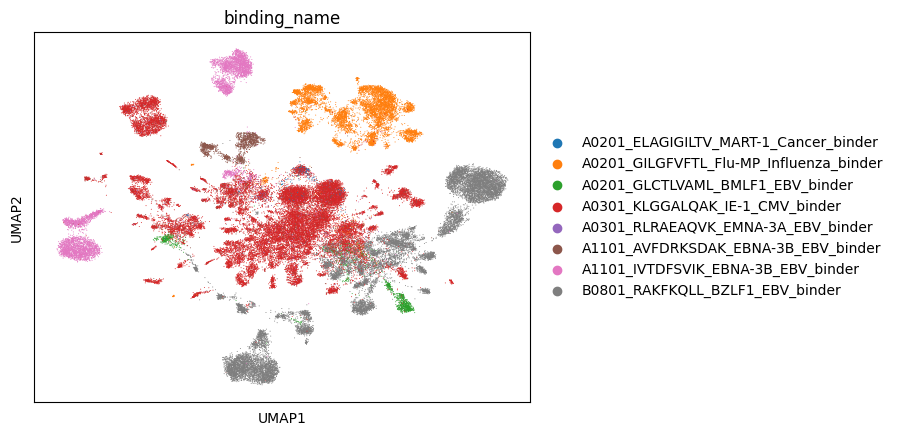

In [6]:
latent_moe = model.get_latent(data, metadata=[], return_mean=True)
latent_moe.obs = data.obs.copy()
sc.pp.neighbors(latent_moe, use_rep='X')
sc.tl.umap(latent_moe)
sc.pl.umap(latent_moe, color=['binding_name'])


In [7]:
unimodal_latent = model.get_all_latent(data, metadata=[], return_mean=True)

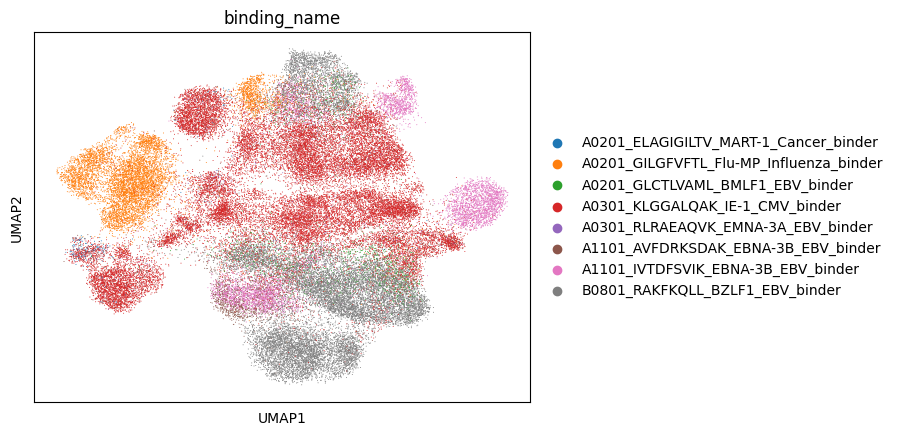

In [8]:
rna_latent = [batch[0].detach().cpu().numpy() for batch in unimodal_latent]
rna_latent = np.vstack(rna_latent)
rna_latent = sc.AnnData(X=rna_latent, obs=data.obs)

sc.pp.neighbors(rna_latent, use_rep='X')
sc.tl.umap(rna_latent)
sc.pl.umap(rna_latent, color=['binding_name'])

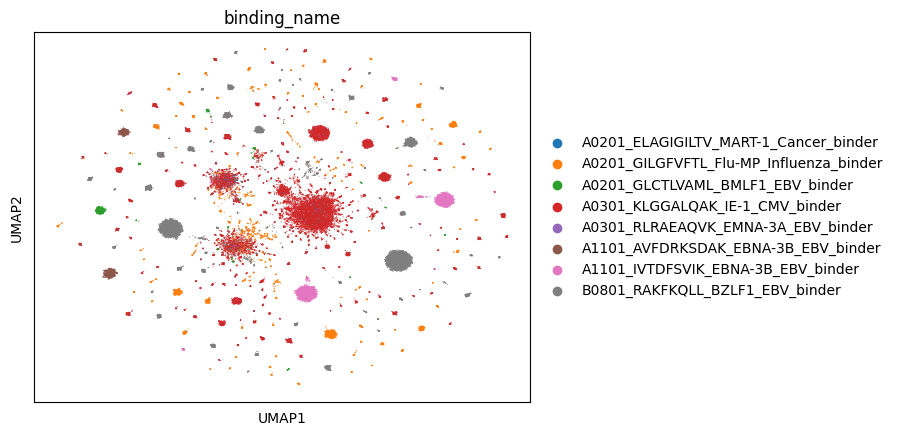

In [9]:
tcr_latent = [batch[1].detach().cpu().numpy() for batch in unimodal_latent]
tcr_latent = np.vstack(tcr_latent)
tcr_latent = sc.AnnData(X=tcr_latent, obs=data.obs)

sc.pp.neighbors(tcr_latent, use_rep='X')
sc.tl.umap(tcr_latent)
sc.pl.umap(tcr_latent, color=['binding_name'])

In [10]:
cp_bind = sb.color_palette('deep')
colors_binders = {
    'RAKFKQLL': cp_bind[2],
    'GILGFVFTL': cp_bind[1],
    'KLGGALQAK': cp_bind[8],
    'GLCTLVAML': cp_bind[3],
    'AVFDRKSDAK': cp_bind[0],
    'IVTDFSVIK': cp_bind[4], 
    'ELAGIGILTV': cp_bind[5],
    'RLRAEAQVK': cp_bind[9],
}
colors_binders_full = {
    'B0801_RAKFKQLL_BZLF1_EBV_binder': cp_bind[2],
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder': cp_bind[1],
    'A0301_KLGGALQAK_IE-1_CMV_binder': cp_bind[8],
    'A0201_GLCTLVAML_BMLF1_EBV_binder': cp_bind[3],
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder': cp_bind[0],
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder': cp_bind[4], 
    'A0201_ELAGIGILTV_MART-1_Cancer_binder': cp_bind[5],
    'A0301_RLRAEAQVK_EMNA-3A_EBV_binder': cp_bind[9],
}

In [11]:
color_list = [colors_binders[el.split('_')[1]] 
              for el in latent_moe.obs['binding_name'].cat.categories]
latent_moe.uns['binding_name_colors'] = color_list
rna_latent.uns['binding_name_colors'] = color_list
tcr_latent.uns['binding_name_colors'] = color_list

categories = latent_moe.obs['binding_name'].cat.categories
categories = [el.split('_')[1] for el in categories]

## Length ;)

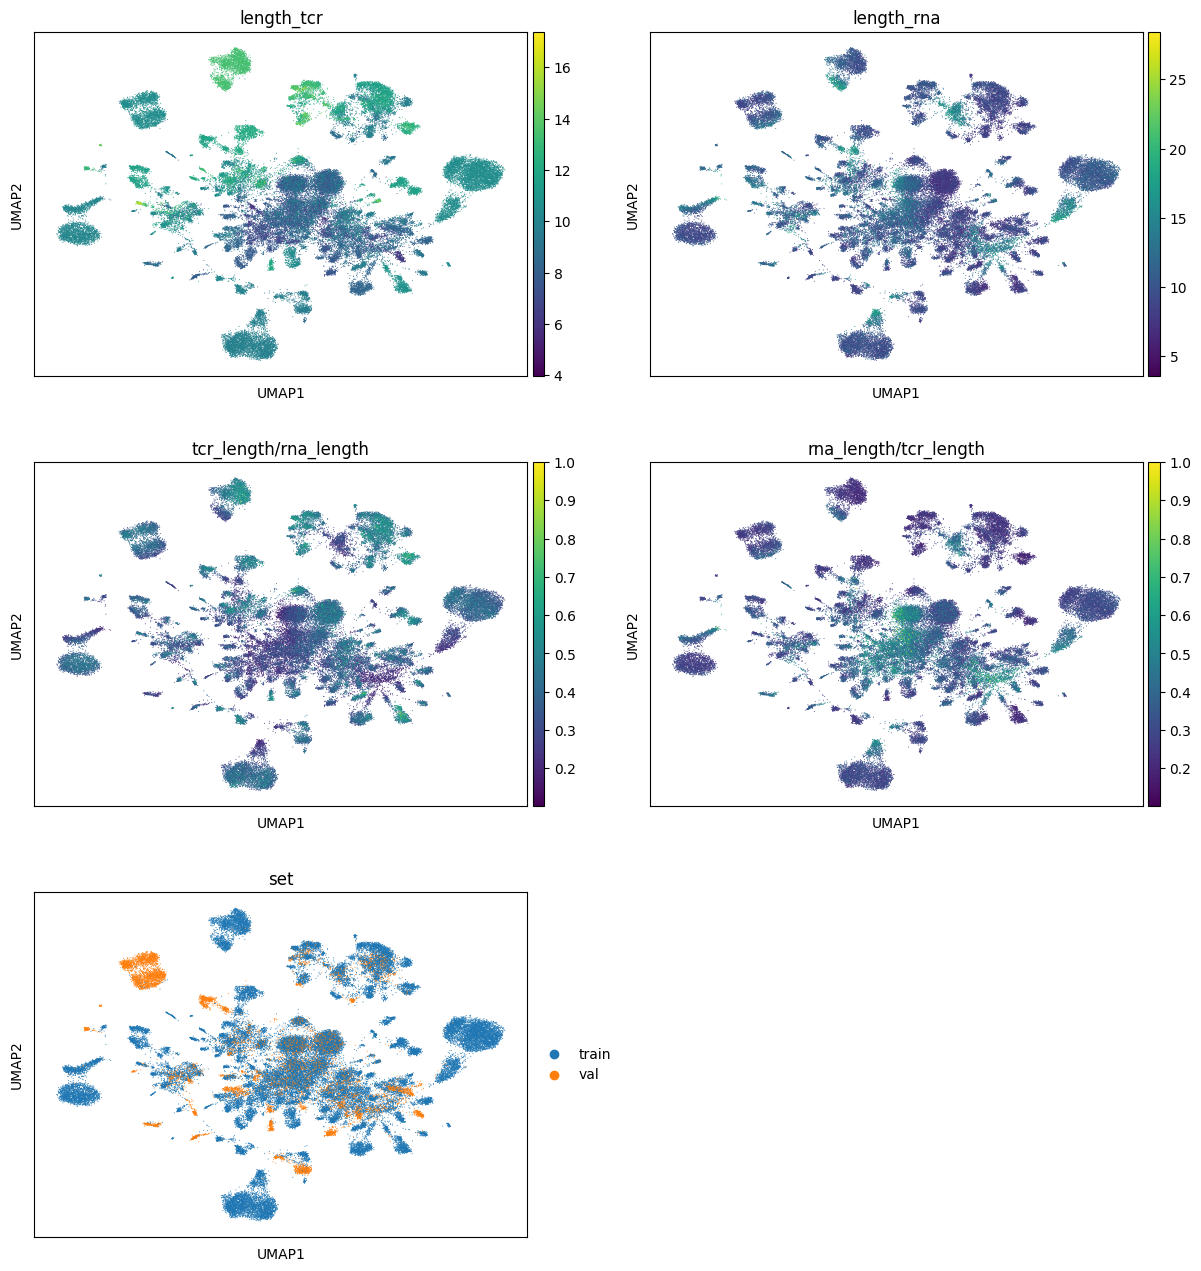

In [13]:
latent_moe.obs['length_tcr'] = np.linalg.norm(tcr_latent.X, axis=1, ord=2)
latent_moe.obs['length_rna'] = np.linalg.norm(rna_latent.X, axis=1, ord=2)

latent_moe.obs['tcr_length/rna_length'] = latent_moe.obs['length_tcr'] / latent_moe.obs['length_rna']
latent_moe.obs['tcr_length/rna_length'] = latent_moe.obs['tcr_length/rna_length'] / latent_moe.obs['tcr_length/rna_length'].max()

latent_moe.obs['rna_length/tcr_length'] = latent_moe.obs['length_rna'] / latent_moe.obs['length_tcr']
latent_moe.obs['rna_length/tcr_length'] = latent_moe.obs['rna_length/tcr_length'] / latent_moe.obs['rna_length/tcr_length'].max()


sc.pl.umap(latent_moe, color=['length_tcr', 'length_rna', 
                              'tcr_length/rna_length', 'rna_length/tcr_length',
                             #'binding_name', 
                              'set'],
          ncols=2)

## Cosine ;)

In [14]:
def cosine_similarity(x, y):
    dot = np.dot(x, y)
    norms = np.linalg.norm(x)*np.linalg.norm(y)
    return dot / norms

In [15]:
latent_moe.obs['cosine_tcr'] = [cosine_similarity(x, y) for x, y in zip(latent_moe.X, tcr_latent.X)]
latent_moe.obs['cosine_rna'] = [cosine_similarity(x, y) for x, y in zip(latent_moe.X, rna_latent.X)]
latent_moe.obs['cosine(tcr-rna)'] = latent_moe.obs['cosine_tcr'] - latent_moe.obs['cosine_rna']
latent_moe.obs['cosine(rna-tcr)'] = latent_moe.obs['cosine_rna'] - latent_moe.obs['cosine_tcr']

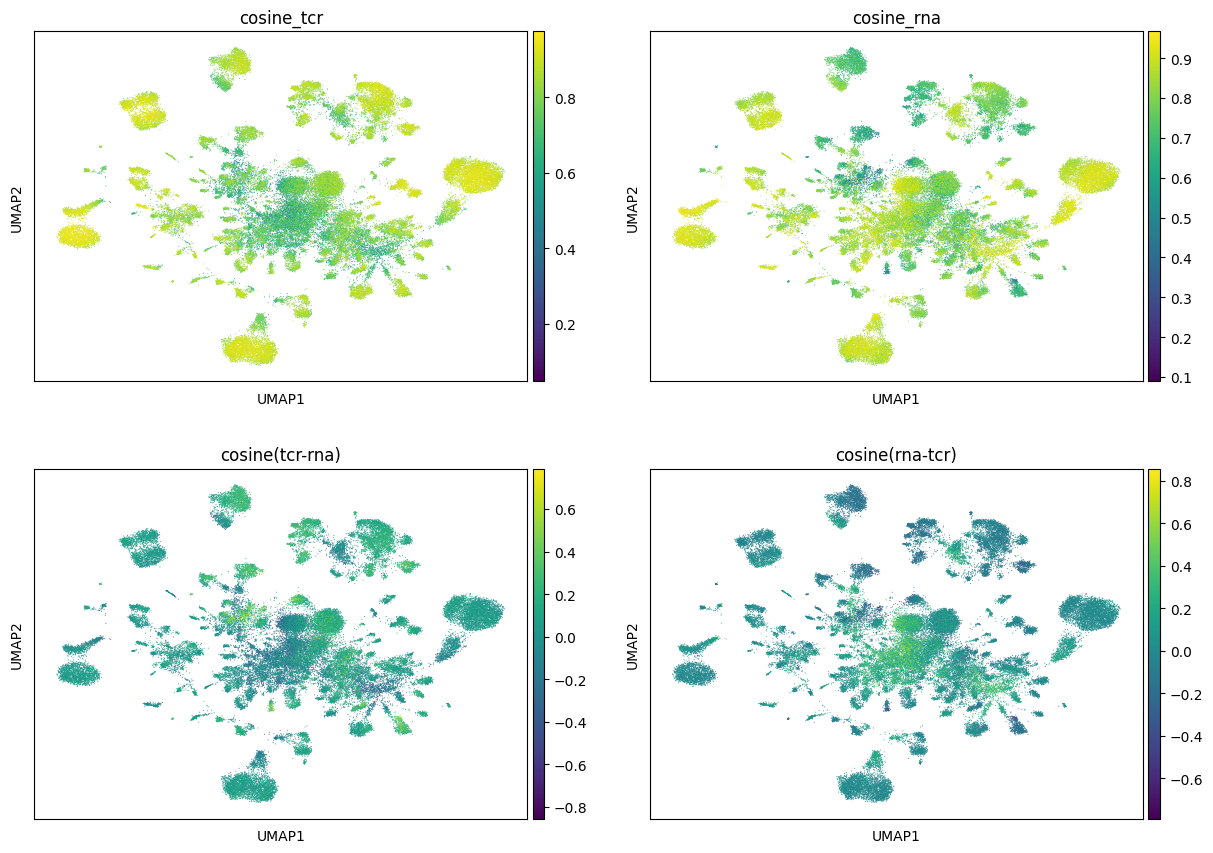

In [17]:
sc.pl.umap(latent_moe, color=['cosine_tcr', 'cosine_rna', 
                              'cosine(tcr-rna)', 'cosine(rna-tcr)',
                             #'binding_name',
                             ],
          ncols=2)

## Angular

In [18]:
def angular_similarity(x, y):
    dot = np.dot(x, y)
    norms = np.linalg.norm(x)*np.linalg.norm(y)
    cos_similarity = dot / norms
    angular = (1 - np.arccos(cos_similarity) / np.pi)
    return angular

In [19]:
latent_moe.obs['angular_tcr'] = [angular_similarity(x, y) for x, y in zip(latent_moe.X, tcr_latent.X)]
latent_moe.obs['angular_rna'] = [angular_similarity(x, y) for x, y in zip(latent_moe.X, rna_latent.X)]
latent_moe.obs['angular(tcr-rna)'] = latent_moe.obs['angular_tcr'] - latent_moe.obs['angular_rna'] + 0.5
latent_moe.obs['angular(rna-tcr)'] = latent_moe.obs['angular_rna'] - latent_moe.obs['angular_tcr'] + 0.5

In [20]:
print(latent_moe.obs['angular(tcr-rna)'].min())
print(latent_moe.obs['angular(tcr-rna)'].max())

0.15247877026027257
0.8320440874850954


In [21]:
print(latent_moe.obs['angular(rna-tcr)'].min())
print(latent_moe.obs['angular(rna-tcr)'].max())

0.1679559125149046
0.8475212297397274


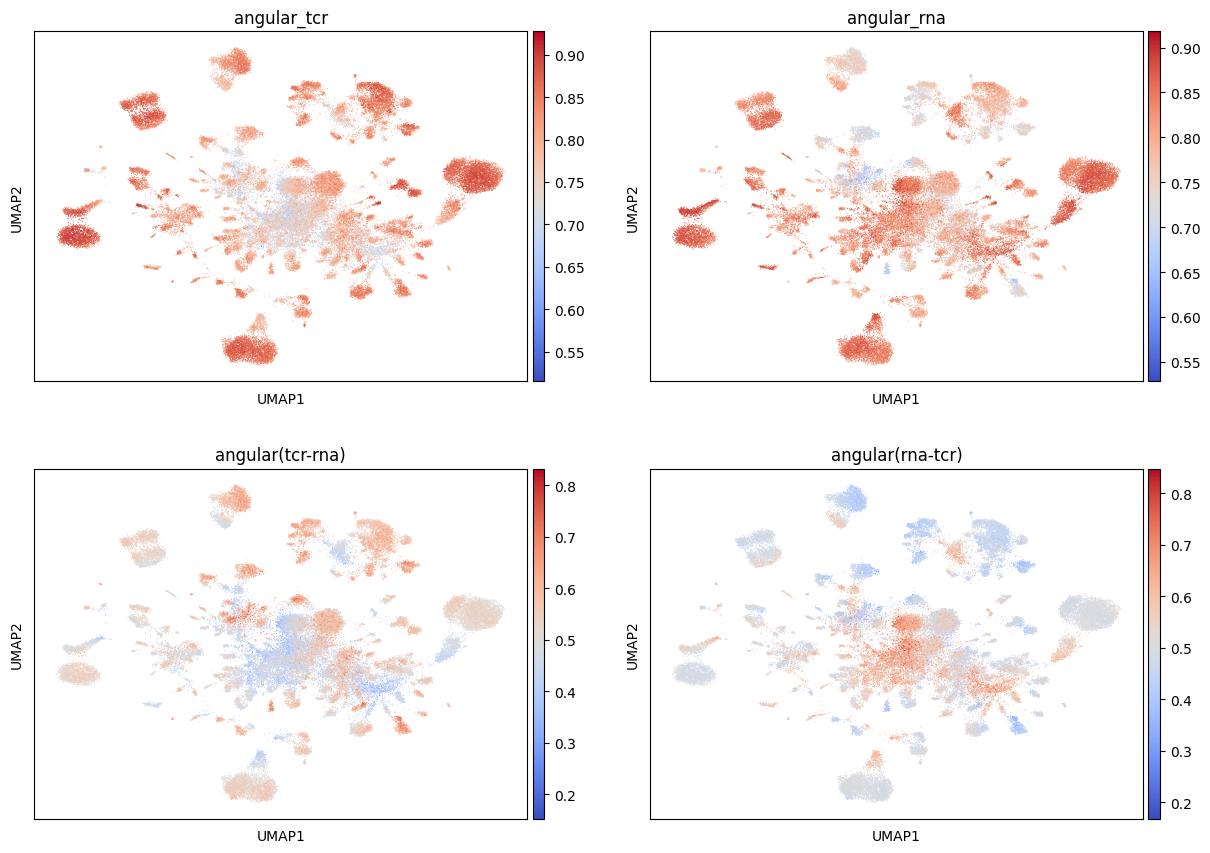

In [33]:
sc.pl.umap(latent_moe, color=['angular_tcr', 'angular_rna', 
                              'angular(tcr-rna)', 'angular(rna-tcr)',
                             ],
           cmap='coolwarm',
          ncols=2)

[Text(0, 0, 'A0201_ELAGIGILTV_MART-1_Cancer_binder'),
 Text(1, 0, 'A0201_GILGFVFTL_Flu-MP_Influenza_binder'),
 Text(2, 0, 'A0201_GLCTLVAML_BMLF1_EBV_binder'),
 Text(3, 0, 'A0301_KLGGALQAK_IE-1_CMV_binder'),
 Text(4, 0, 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder'),
 Text(5, 0, 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder'),
 Text(6, 0, 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder'),
 Text(7, 0, 'B0801_RAKFKQLL_BZLF1_EBV_binder')]

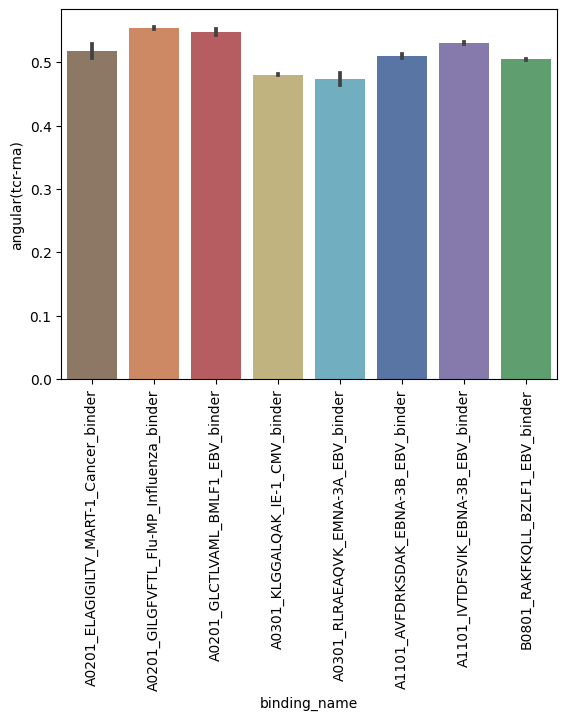

In [24]:
plot = sb.barplot(data=latent_moe.obs, y='angular(tcr-rna)', x='binding_name',
           palette=colors_binders_full)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

In [28]:
order = latent_moe.obs.groupby('binding_name')[
    'angular(tcr-rna)'].mean().sort_values(ascending=False).index.tolist()
order

['A0201_GILGFVFTL_Flu-MP_Influenza_binder',
 'A0201_GLCTLVAML_BMLF1_EBV_binder',
 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
 'A0201_ELAGIGILTV_MART-1_Cancer_binder',
 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
 'B0801_RAKFKQLL_BZLF1_EBV_binder',
 'A0301_KLGGALQAK_IE-1_CMV_binder',
 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder']

[Text(0, 0, 'A0201_GILGFVFTL_Flu-MP_Influenza_binder'),
 Text(1, 0, 'A0201_GLCTLVAML_BMLF1_EBV_binder'),
 Text(2, 0, 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder'),
 Text(3, 0, 'A0201_ELAGIGILTV_MART-1_Cancer_binder'),
 Text(4, 0, 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder'),
 Text(5, 0, 'B0801_RAKFKQLL_BZLF1_EBV_binder'),
 Text(6, 0, 'A0301_KLGGALQAK_IE-1_CMV_binder'),
 Text(7, 0, 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder')]

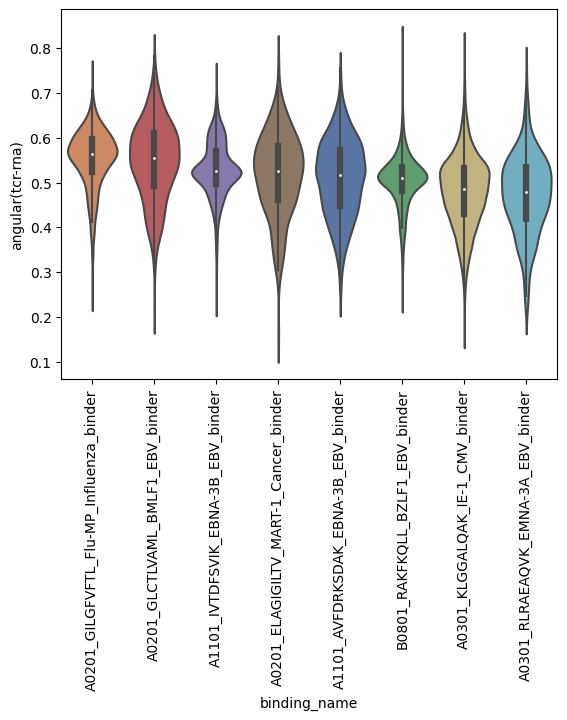

In [34]:
plot = sb.violinplot(data=latent_moe.obs, y='angular(tcr-rna)', x='binding_name',
           palette=colors_binders_full,
                    order=order,
                     scale='width'
                    )
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

# Evaluation

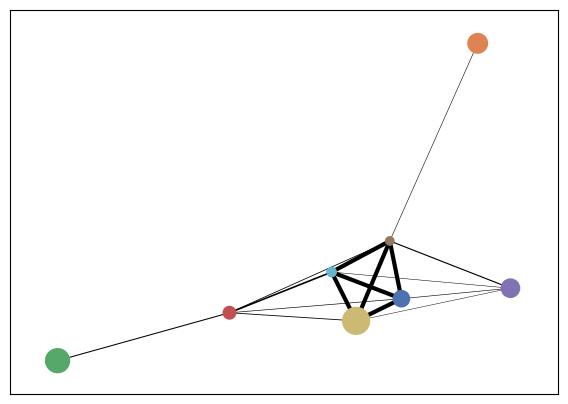

,ELAGIGILTV,GILGFVFTL,GLCTLVAML,KLGGALQAK,RLRAEAQVK,AVFDRKSDAK,IVTDFSVIK,RAKFKQLL
ELAGIGILTV,0.000000,0.134030,0.189664,1.000000,1.000000,1.000000,0.272706,0.077651
GILGFVFTL,0.134030,0.000000,0.023822,0.043225,0.049910,0.043396,0.006758,0.009603
GLCTLVAML,0.189664,0.023822,0.000000,0.196642,0.388619,0.152764,0.024240,0.248694
KLGGALQAK,1.000000,0.043225,0.196642,0.000000,1.000000,1.000000,0.111459,0.051100
RLRAEAQVK,1.000000,0.049910,0.388619,1.000000,0.000000,1.000000,0.119032,0.089064
AVFDRKSDAK,1.000000,0.043396,0.152764,1.000000,1.000000,0.000000,0.141093,0.051917
IVTDFSVIK,0.272706,0.006758,0.024240,0.111459,0.119032,0.141093,0.000000,0.016447
RAKFKQLL,0.077651,0.009603,0.248694,0.051100,0.089064,0.051917,0.016447,0.000000


In [17]:
sc.tl.paga(latent_moe, groups='binding_name')
sc.pl.paga(latent_moe, color='binding_name', labels=['']*8, 
           threshold=0.1,
           edge_width_scale=0.4)
pd.DataFrame(data=latent_moe.uns['paga']['connectivities'].A, index=categories, columns=categories)

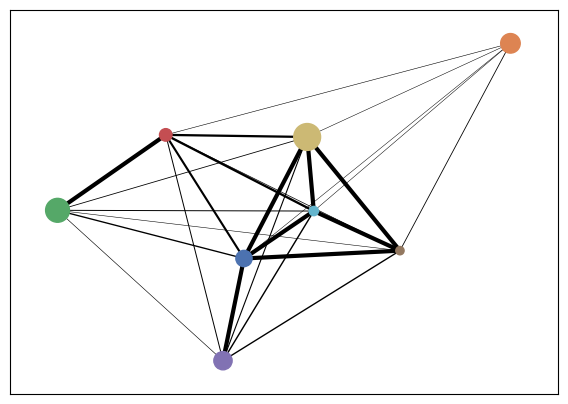

,ELAGIGILTV,GILGFVFTL,GLCTLVAML,KLGGALQAK,RLRAEAQVK,AVFDRKSDAK,IVTDFSVIK,RAKFKQLL
ELAGIGILTV,0.000000,0.197971,0.167780,1.000000,1.000000,1.000000,0.330455,0.126665
GILGFVFTL,0.197971,0.000000,0.132925,0.122847,0.120096,0.117608,0.033474,0.035572
GLCTLVAML,0.167780,0.132925,0.000000,0.542819,0.559796,0.506876,0.238052,1.000000
KLGGALQAK,1.000000,0.122847,0.542819,0.000000,1.000000,1.000000,0.266719,0.194542
RLRAEAQVK,1.000000,0.120096,0.559796,1.000000,0.000000,1.000000,0.341836,0.231566
AVFDRKSDAK,1.000000,0.117608,0.506876,1.000000,1.000000,0.000000,1.000000,0.322050
IVTDFSVIK,0.330455,0.033474,0.238052,0.266719,0.341836,1.000000,0.000000,0.145181
RAKFKQLL,0.126665,0.035572,1.000000,0.194542,0.231566,0.322050,0.145181,0.000000


In [18]:
sc.tl.paga(rna_latent, groups='binding_name')
sc.pl.paga(rna_latent, color='binding_name', 
           labels=['']*8, 
           threshold=0.1,
           edge_width_scale=0.4)
pd.DataFrame(data=rna_latent.uns['paga']['connectivities'].A, index=categories, columns=categories)

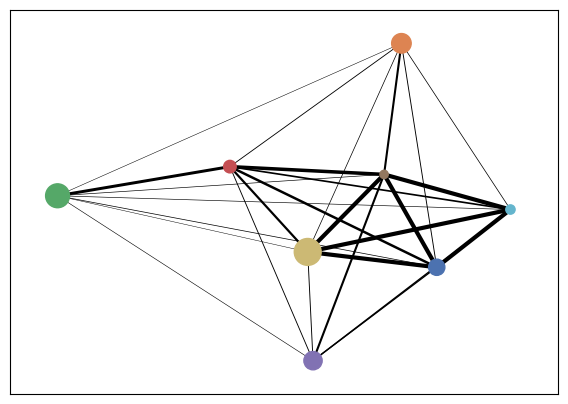

,ELAGIGILTV,GILGFVFTL,GLCTLVAML,KLGGALQAK,RLRAEAQVK,AVFDRKSDAK,IVTDFSVIK,RAKFKQLL
ELAGIGILTV,0.000000,0.499218,0.837715,1.000000,1.000000,1.000000,0.503600,0.155222
GILGFVFTL,0.499218,0.000000,0.208287,0.170599,0.177009,0.220148,0.095831,0.122207
GLCTLVAML,0.837715,0.208287,0.000000,0.531985,0.403718,0.600823,0.216492,0.711512
KLGGALQAK,1.000000,0.170599,0.531985,0.000000,1.000000,1.000000,0.219850,0.111328
RLRAEAQVK,1.000000,0.177009,0.403718,1.000000,0.000000,1.000000,0.335773,0.148708
AVFDRKSDAK,1.000000,0.220148,0.600823,1.000000,1.000000,0.000000,0.305294,0.169501
IVTDFSVIK,0.503600,0.095831,0.216492,0.219850,0.335773,0.305294,0.000000,0.140295
RAKFKQLL,0.155222,0.122207,0.711512,0.111328,0.148708,0.169501,0.140295,0.000000


In [19]:
sc.tl.paga(tcr_latent, groups='binding_name')
sc.pl.paga(tcr_latent, color='binding_name', labels=['']*8, 
           threshold=0.1,
           edge_width_scale=0.4)
pd.DataFrame(data=tcr_latent.uns['paga']['connectivities'].A, index=categories, columns=categories)

In [20]:
from scipy.stats import ttest_ind
for binding in latent_moe.obs['binding_name'].unique():
    val_bind = latent_moe[latent_moe.obs['binding_name']==binding].obs['cosine(tcr-rna)']
    val_nonbind = latent_moe[latent_moe.obs['binding_name']!=binding].obs['cosine(tcr-rna)']
    print(f'{binding.split("_")[1]}: {ttest_ind(val_bind, val_nonbind)}')
latent_moe.obs.groupby('binding_name')['cosine(tcr-rna)'].mean()

KLGGALQAK: Ttest_indResult(statistic=-64.92143982196409, pvalue=0.0)
IVTDFSVIK: Ttest_indResult(statistic=25.826124045850996, pvalue=2.753843873779297e-146)
GILGFVFTL: Ttest_indResult(statistic=59.24605829923205, pvalue=0.0)
AVFDRKSDAK: Ttest_indResult(statistic=7.205631142653223, pvalue=5.843918595414848e-13)
RLRAEAQVK: Ttest_indResult(statistic=-7.475453952849399, pvalue=7.79596544887987e-14)
ELAGIGILTV: Ttest_indResult(statistic=3.3502403370042853, pvalue=0.0008079022053893955)
RAKFKQLL: Ttest_indResult(statistic=1.2902457231519944, pvalue=0.19697022749526316)
GLCTLVAML: Ttest_indResult(statistic=21.528513606677073, pvalue=2.022378552826536e-102)


binding_name
A0201_ELAGIGILTV_MART-1_Cancer_binder      0.038705
A0201_GILGFVFTL_Flu-MP_Influenza_binder    0.104847
A0201_GLCTLVAML_BMLF1_EBV_binder           0.100512
A0301_KLGGALQAK_IE-1_CMV_binder           -0.042431
A0301_RLRAEAQVK_EMNA-3A_EBV_binder        -0.056838
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder        0.023141
A1101_IVTDFSVIK_EBNA-3B_EBV_binder         0.056294
B0801_RAKFKQLL_BZLF1_EBV_binder            0.005640
Name: cosine(tcr-rna), dtype: float64

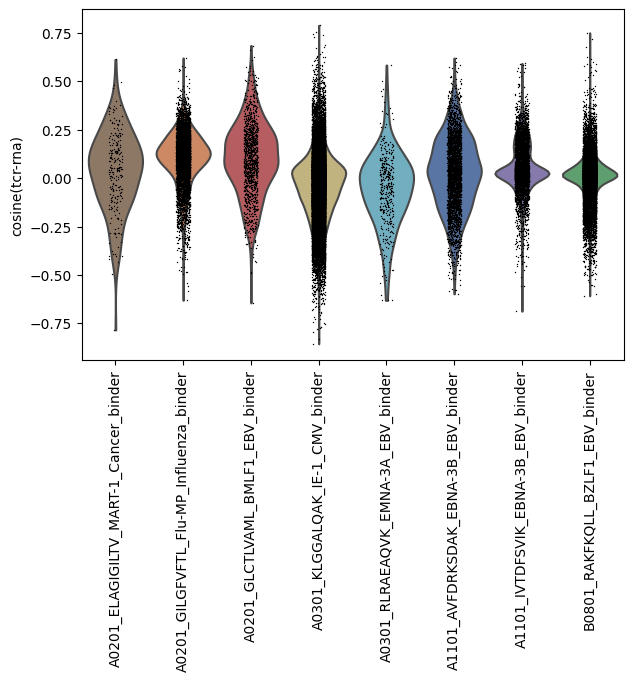

In [21]:
sc.pl.violin(latent_moe, keys='cosine(tcr-rna)', groupby='binding_name', rotation=90)

[Text(0, 0, 'A0201_ELAGIGILTV_MART-1_Cancer_binder'),
 Text(1, 0, 'A0201_GILGFVFTL_Flu-MP_Influenza_binder'),
 Text(2, 0, 'A0201_GLCTLVAML_BMLF1_EBV_binder'),
 Text(3, 0, 'A0301_KLGGALQAK_IE-1_CMV_binder'),
 Text(4, 0, 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder'),
 Text(5, 0, 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder'),
 Text(6, 0, 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder'),
 Text(7, 0, 'B0801_RAKFKQLL_BZLF1_EBV_binder')]

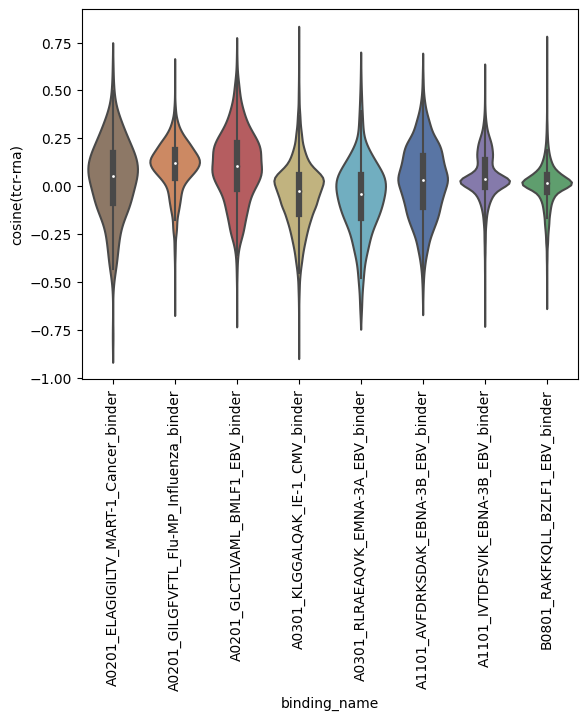

In [22]:
plot = sb.violinplot(data=latent_moe.obs, y='cosine(tcr-rna)', x='binding_name', scale='width',
           palette=colors_binders_full)

plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

[Text(0, 0, 'A0201_ELAGIGILTV_MART-1_Cancer_binder'),
 Text(1, 0, 'A0201_GILGFVFTL_Flu-MP_Influenza_binder'),
 Text(2, 0, 'A0201_GLCTLVAML_BMLF1_EBV_binder'),
 Text(3, 0, 'A0301_KLGGALQAK_IE-1_CMV_binder'),
 Text(4, 0, 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder'),
 Text(5, 0, 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder'),
 Text(6, 0, 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder'),
 Text(7, 0, 'B0801_RAKFKQLL_BZLF1_EBV_binder')]

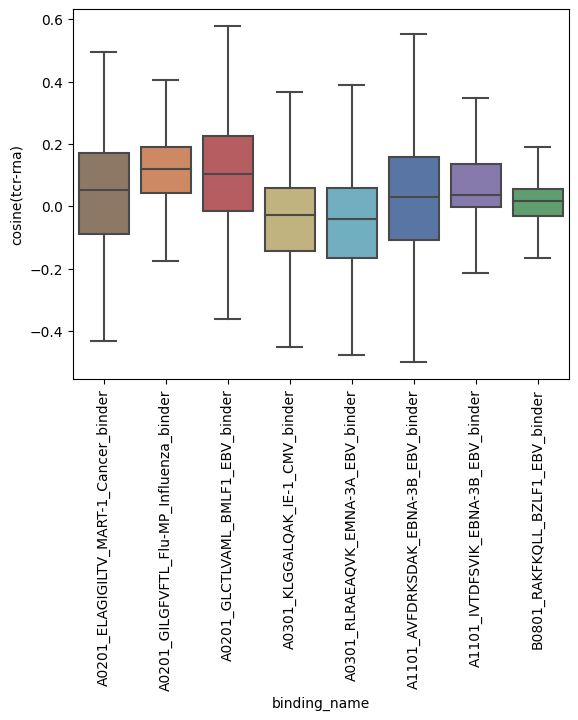

In [23]:
plot = sb.boxplot(data=latent_moe.obs, y='cosine(tcr-rna)', x='binding_name', showfliers=False,
           palette=colors_binders_full)

plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

## Probability ;)

In [ ]:
from scipy.stats import norm

In [ ]:
latent_moe.obs['prob_rna'] = norm.pdf(latent_moe.obs['length_rna'])
latent_moe.obs['prob_tcr'] = norm.pdf(latent_moe.obs['length_tcr'])

latent_moe.obs['prob_ratio(tcr/rna)'] = latent_moe.obs['prob_tcr'] / latent_moe.obs['prob_rna']

In [ ]:
sc.pl.umap(latent_moe, color=['prob_tcr', 'prob_rna', 
                              'length_tcr', 'length_rna',
                             'binding_name', 'prob_ratio(tcr/rna)'],
          ncols=2)

## Haniffa

In [ ]:
def load_haniffa_data():
    adata = utils.load_data('Haniffa')
    return adata

In [ ]:
def load_haniffa_model(adata, weight=1):
    path_model = f'saved_models/journal/Haniffa/haniffa_tcr_moe_{weight}.pt'
    model = utils.load_model(adata, path_model)
    return model

In [ ]:
data_han = load_haniffa_data()
model_han = load_haniffa_model(data_han)

In [ ]:
latent_moe_han = model_han.get_latent(data_han, metadata=[], return_mean=True)
latent_moe_han.obs = data_han.obs.copy()
sc.pp.neighbors(latent_moe_han, use_rep='X')
sc.tl.umap(latent_moe_han)
sc.pl.umap(latent_moe_han, color=['full_clustering'])

In [ ]:
unimodal_latent_han = model_han.get_all_latent(data_han, metadata=[], return_mean=True)

In [ ]:
rna_latent_han = [batch[0].detach().cpu().numpy() for batch in unimodal_latent_han]
rna_latent_han = np.vstack(rna_latent_han)
rna_latent_han = sc.AnnData(X=rna_latent_han, obs=data_han.obs)

sc.pp.neighbors(rna_latent_han, use_rep='X')
sc.tl.umap(rna_latent_han)
sc.pl.umap(rna_latent_han, color=['full_clustering'])

In [ ]:
tcr_latent_han = [batch[1].detach().cpu().numpy() for batch in unimodal_latent_han]
tcr_latent_han = np.vstack(tcr_latent_han)
tcr_latent_han = sc.AnnData(X=tcr_latent_han, obs=data_han.obs)

sc.pp.neighbors(tcr_latent_han, use_rep='X')
sc.tl.umap(tcr_latent_han)
sc.pl.umap(tcr_latent_han, color=['full_clustering'])

In [ ]:
latent_moe_han.obs['cosine_tcr'] = [cosine_similarity(x, y) 
                                for x, y in zip(latent_moe_han.X, tcr_latent_han.X)]
latent_moe_han.obs['cosine_rna'] = [cosine_similarity(x, y) 
                                for x, y in zip(latent_moe_han.X, rna_latent_han.X)]
latent_moe_han.obs['cosine(tcr-rna)'] = latent_moe_han.obs['cosine_tcr'] - latent_moe_han.obs['cosine_rna']
latent_moe_han.obs['cosine(rna-tcr)'] = latent_moe_han.obs['cosine_rna'] - latent_moe_han.obs['cosine_tcr']

sc.pl.umap(latent_moe_han, color=['cosine_tcr', 'cosine_rna', 
                              'cosine(tcr-rna)', 'cosine(rna-tcr)',
                             'full_clustering',],
          ncols=2)